In [ ]:
# %matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### Parameters

In [ ]:
# Parameters
L = 100*10**3.0
Total_time = 300000.0
g = 9.81
viscosity = 10**(2)
Nx = 500 #real points aside from boundary
# N_t = 200
dx = L / (Nx)
x = np.linspace(0, L, Nx)

### Boundarie Conditions

In [ ]:
# #Boundary conditions
# h_left = lambda t: 0#Can make boundary a function of t
# h_right = lambda t: 0

u_left = lambda t: 0
u_left_prime = lambda t: 0
u_right = lambda t: 0
u_right_prime = lambda t: 0

# Initial conditions
h_initial = np.ones(Nx, dtype=np.float64)
u_initial = np.zeros(Nx, dtype=np.float64)

# Add a perturbation as for the moment initial conditions are regular
h_initial[Nx//2 - 50:Nx//2 + 50] += 0.5

In [ ]:
def central_difference(v, dx, i):
    return (v[i+1] - v[i-1])/(2*dx)

def second_order_central_difference(v, dx, i):
    return (v[i+1] - 2 * v[i] + v[i-1])/(dx**2)

def mod_foward_difference(v, dx, i):
    return (-3*v[i] + 4 * v[i+1] - v[i+2])/(2 * dx)

def mod_backward_difference(v, dx, i):
    return (3*v[i] - 4 * v[i-1] + v[i-2])/(2 * dx)

In [95]:
def pde_system_viscosity(t, y): #No boundary conditions for h
    h = y[:Nx] # 0 Index used for point at boundary
    u = y[Nx:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(Nx, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(Nx, dtype=np.float64)
    dh_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)

    for i in range(1, Nx - 1):
        dh_dx[i + 1] = central_difference(h, dx, i + 1)
        du_dx[i] = central_difference(u, dx, i)

    #Differential equations for points next to the boundary and boundary
    dh_dt[0] = - h[0] * u_left_prime(t) - u[0] * mod_foward_difference(h, dx, 0) #Left Boundary
    dh_dt[Nx + 1] = -h[Nx + 1] * u_right_prime(t)  - u_right(t) * mod_backward_difference(h, dx, Nx + 1) #Right Boundary

    du_dt[0] = -1/(2*dx) * (g*(h[2] - h[0]) + u[0]*(u[1] - u_left(t))) + viscosity * 1/(dx**2) * (u_left(t) - 2 * u[0] + u[1]) #First point after boundary
    dh_dt[1] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h[0])) #First point in grid outside boundary

    dh_dt[Nx] = -1/(2*dx) * (h[Nx] * (u_right(t) - u[Nx - 2])  - u[Nx - 1] * (h[Nx + 1] - h[Nx - 1])) #Last point before boundary
    du_dt[Nx - 1] = -1/(2*dx) * (g*(h[Nx + 1] - h[Nx - 1]) + u[Nx - 1]*(u_right(t) - u[Nx - 2])) + (
        viscosity *  1/(dx**2) * (u_right(t) - 2 * u[Nx - 1] + u[Nx -2])
    ) #Last point before boundary

    #Differential equations for other points
    for i in range(1, Nx - 1):
        dh_dt[i + 1] = - h[i + 1] * du_dx[i + 1] - u[i + 1] * dh_dx[i + 1]
        du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i] + viscosity * second_order_central_difference(u, dx, i)
    
    return np.concatenate((dh_dt, du_dt))

In [96]:
def pde_system_extrapolation(t, y): #No boundary conditions for h
    h = y[:Nx] # 0 Index used for point at boundary
    u = y[Nx:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(Nx, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(Nx, dtype=np.float64)
    dh_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)

    for i in range(1, Nx - 1):
        dh_dx[i + 1] = central_difference(h, dx, i + 1)
        du_dx[i] = central_difference(u, dx, i)

    du_dt[0] = -1/(2*dx) * (g*(h[2] - h[0]) + u[0]*(u[1] - u_left(t))) + viscosity * 1/(dx**2) * (u_left(t) - 2 * u[0] + u[1]) #First point after boundary
    dh_dt[1] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h[0])) #First point in grid outside boundary

    dh_dt[Nx] = -1/(2*dx) * (h[Nx] * (u_right(t) - u[Nx - 2])  - u[Nx - 1] * (h[Nx + 1] - h[Nx - 1])) #Last point before boundary
    du_dt[Nx - 1] = -1/(2*dx) * (g*(h[Nx + 1] - h[Nx - 1]) + u[Nx - 1]*(u_right(t) - u[Nx - 2])) + (
        viscosity *  1/(dx**2) * (u_right(t) - 2 * u[Nx - 1] + u[Nx -2])) #Last point before boundary

    #Differential equations for other points
    for i in range(1, Nx - 1):
        dh_dt[i + 1] = - h[i + 1] * du_dx[i + 1] - u[i + 1] * dh_dx[i + 1]
        du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i] + viscosity * second_order_central_difference(u, dx, i)
    dh_dt[0] = dh_dt[1]
    dh_dt[Nx + 1] = dh_dt[Nx]
    return np.concatenate((dh_dt, du_dt))

In [97]:
def pde_system_modified(t, y): #No boundary conditions for h
    h = y[:Nx] # 0 Index used for point at boundary
    u = y[Nx:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(Nx, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(Nx, dtype=np.float64)
    dh_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)

    for i in range(1, Nx - 1):
        dh_dx[i + 1] = central_difference(h, dx, i + 1)
        du_dx[i] = central_difference(u, dx, i)

    #Differential equations for points next to the boundary and boundary
    dh_dt[0] = - h[0] * u_left_prime(t) - u[0] * mod_foward_difference(h, dx, 0) #Left Boundary
    dh_dt[Nx + 1] = -h[Nx + 1] * u_right_prime(t)  - u_right(t) * mod_backward_difference(h, dx, Nx + 1) #Right Boundary

    du_dt[0] = -1/(2*dx) * (g*(h[2] - h[0]) + u[0]*(u[1] - u_left(t))) #First point after boundary
    dh_dt[1] = -1/(2*dx) * (h[0] * (u[1] - u_left(t))  - u[0] * (h[1] - h[0])) #First point in grid outside boundary

    dh_dt[Nx] = -1/(2*dx) * (h[Nx] * (u_right(t) - u[Nx - 2])  - u[Nx - 1] * (h[Nx + 1] - h[Nx - 1])) #Last point before boundary
    du_dt[Nx - 1] = -1/(2*dx) * (g*(h[Nx + 1] - h[Nx - 1]) + u[Nx - 1]*(u_right(t) - u[Nx - 2])) #Last point before boundary

    #Differential equations for other points
    for i in range(1, Nx - 1):
        dh_dt[i + 1] = - h[i + 1] * du_dx[i + 1] - u[i + 1] * dh_dx[i + 1]
        du_dt[i] = - u[i] * du_dx[i] - g * dh_dx[i]
    
    return np.concatenate((dh_dt, du_dt))

In [98]:
def pde_system_vector_op(t, y): #No boundary conditions for h
    h = y[:Nx] # 0 Index used for point at boundary
    u = y[Nx:]# 0 index used for first real point in grid after boundary

    dh_dx = np.zeros(Nx, dtype=np.float64) #Also consider boundary for h
    du_dx = np.zeros(Nx, dtype=np.float64)
    dh_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)


    dh_dx[1:-1] = (h[2:] - h[:-2]) / (2 * dx)
    du_dx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
    dh_dt[1:-1] = -h[1:-1] * du_dx[1:-1] - u[1:-1] * dh_dx[1:-1]
    du_dt[1:-1] = -u[1:-1] * du_dx[1:-1] - g * dh_dx[1:-1] + viscosity *(u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    return np.concatenate((dh_dt, du_dt))

### Solving the System

In [99]:
def compute_time_step_1D(y):
    safety_factor = 0.7
    h = y[:Nx]
    u = y[Nx:]
    evals_1 = abs(u - np.sqrt(g*h))
    evals_2 = abs(u + np.sqrt(g*h))
    max_eval = max([max(evals_1), max(evals_2)])
    time_step = safety_factor * dx /max_eval
    return time_step

In [101]:
def rungeKutta_1D(y0, tspan, ode):
    t0, tend = tspan
    t = [t0]
    y = [y0]

    # Determine the number of time steps
    current_time = t0
    h_data = []
    step = 0

    while t0<tend:
        delta_t = compute_time_step_1D(y[-1])
        k1 = delta_t * ode(t0, y[-1])
        k2 = delta_t * ode(t0 + 0.5 * delta_t, y[-1] + 0.5 * k1)
        k3 = delta_t * ode(t0 + 0.5 * delta_t, y[-1] + 0.5 * k2)
        k4 = delta_t * ode(t0 + delta_t, y[-1] + k3)

        y_next = y[-1] + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Apply boundary conditions
        h_next = y_next[: (Nx)]
        u_next = y_next[Nx:]
        # Boundarie Conditions for reflecting walls
        u_next[0] = u_left(t0)
        u_next[-1] = u_right(t0)
        h_next[0] = h_next[1]
        h_next[-1] = h_next[-2]

        # Flatten y_next back into a vector
        y_next = np.concatenate((h_next, u_next))

        t0 += delta_t
        t.append(t0)
        y.append(y_next)
        step += 1
        
        if step % 10 == 0:
            h_data.append(h_next.copy())

    return t, y, np.array(h_data)


In [102]:
y0 = np.concatenate((h_initial, u_initial))
t_values, solution_values, h_data = rungeKutta_1D(y0, (0.0, Total_time), pde_system_vector_op)

In [103]:
# t0 = 0
# tf = Total_time
# y0 = np.concatenate((h_initial, u_initial))
# sol1 = solve_ivp(pde_system_modified, t_span=(0,tf), y0=y0, method="RK45")

In [104]:
# t0 = 0
# tf = Total_time
# y0 = np.concatenate((h_initial, u_initial))
# sol1 = solve_ivp(pde_system_extrapolation, t_span=(0,tf), y0=y0, method="LSODA")

In [105]:
# t0 = 0
# tf = Total_time
# y0 = np.concatenate((h_initial, u_initial))
# sol1 = solve_ivp(pde_system_modified, t_span=(0,tf), y0=y0, method="RK45")

In [106]:
#Retrieve information from solution of IVP
# h_results_no_boundary = sol1.y[:Nx]
h_results = h_data
u_results_no_boundary = solution_values[Nx:]
t_points = t_values
# Create a meshgrid for the 3D plot
T, X = np.meshgrid(t_points,x)

In [107]:
X1, T1 = np.meshgrid(x, t_points) #To consider correct orientation of axis

In [108]:
len(h_data.T)

500

In [109]:
t_points

[0.0,
 36.49622139360284,
 69.68733025879818,
 101.44280491573815,
 132.97161265203854,
 164.20586898803103,
 195.3872536613338,
 227.35918334675046,
 258.9351190254846,
 290.56475050331704,
 321.85069730247346,
 353.61103033937985,
 385.12568526413156,
 416.725809558238,
 448.0953818935182,
 479.74889824546534,
 511.2481170888933,
 542.7316903999412,
 574.1871440578876,
 605.6711395337896,
 637.2295184277813,
 668.6256032927613,
 700.2148484822608,
 731.6187763085279,
 763.2304502653449,
 794.6168164766406,
 826.1277232715202,
 857.556904131854,
 888.9724146434443,
 920.4458059429726,
 951.816055714801,
 983.3758613916964,
 1014.7205940242699,
 1046.2443830070786,
 1077.6046945716232,
 1109.0179022623713,
 1140.4185563778178,
 1171.7630256177567,
 1203.2376575107803,
 1234.5467749560016,
 1266.0662847704211,
 1297.3783524348862,
 1328.7762814565094,
 1360.1240186154503,
 1391.44204425207,
 1422.8585584376822,
 1454.134935966269,
 1485.6386908846066,
 1516.912310104519,
 1548.288298735

In [110]:
# # h_left_boundary_evolution = np.array([[h_left(t) for t in t_points]]) #Evolution of boundary for results vector
# # h_right_boundary_evolution = np.array([[h_right(t) for t in t_points]])
# u_left_boundary_evolution = np.array([[u_left(t) for t in t_points]])
# u_right_boundary_evolution = np.array([[u_right(t) for t in t_points]])

# # h_results = np.concatenate((h_left_boundary_evolution, h_results_no_boundary, h_right_boundary_evolution)) #Add boundaries to results
# u_results = np.concatenate((u_left_boundary_evolution, u_results_no_boundary, u_right_boundary_evolution))

# h_results1 = h_results.transpose() #Used for orientation of axis
# u_results1 = u_results.transpose()

### Plotting

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8161, 500) and arg 2 with shape (816, 500).

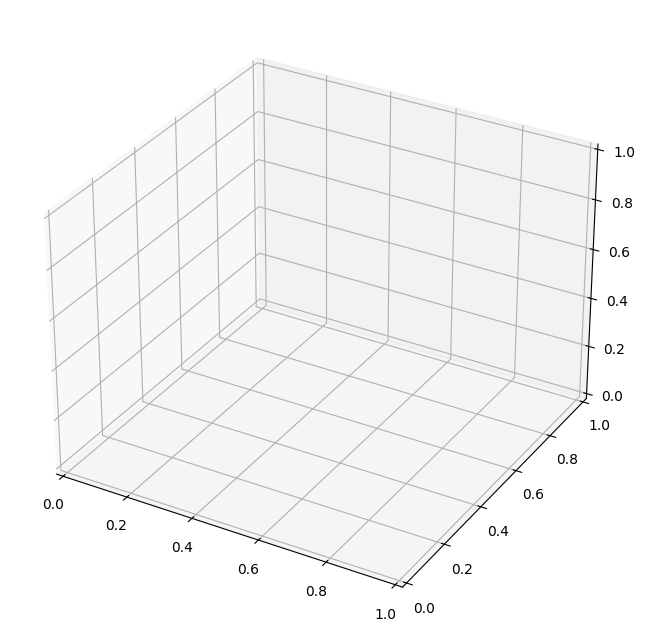

In [111]:
# Plot height (h) as a 3D surface
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1, T1, h_results, cmap='viridis', edgecolor='none')
ax.set_xlabel('x (Spatial Grid)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('h (Height)')
ax.set_title('Height Profile Over Time')
plt.show()

# Plot velocity (u) as a 3D surface
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1, T1, u_results, cmap='plasma', edgecolor='none')
ax.set_xlabel('x (Spatial Grid)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('u (Velocity)')
ax.set_title('Velocity Profile Over Time')
plt.show()

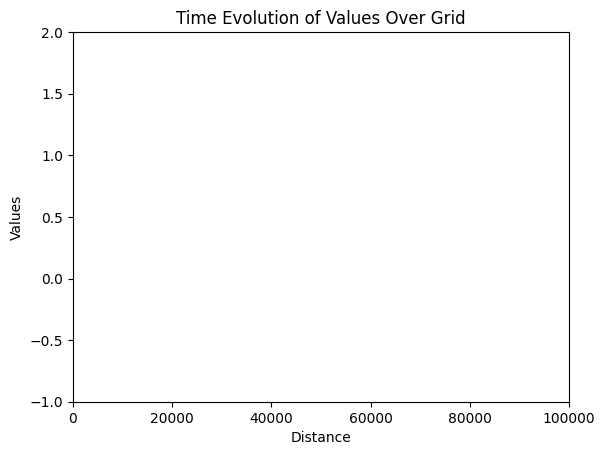

MovieWriter ffmpeg unavailable; using Pillow instead.


In [112]:
# Create the figure and axis
time_steps = len(h_results)
values = h_results
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Set up the plot limits
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-1, 2)
ax.set_xlabel("Distance")
ax.set_ylabel("Values")
ax.set_title("Time Evolution of Values Over Grid")

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Animation function to update the plot
def update(frame):
    y = values[frame, :]  # Values at the current time step
    line.set_data(x, y)   # Update the line with grid points and corresponding values
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, init_func=init, blit=True, interval=20)

# Display the animation
plt.show()
ani.save('animation.gif', writer='ffmpeg', fps=30)